In [48]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

# from config import db_password

import time

In [49]:
#  Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    return movie

In [71]:
# 1 Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load(x,y,z):

    # 2. Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    # 3. Open the read the Wikipedia data JSON file.

    # 4. Read in the raw wiki movie data as a Pandas DataFrame.
    # 5. Return the three DataFrames 
    kaggle_metadata = pd.read_csv(y)
    ratings = pd.read_csv(z)    
    with open(x, mode='r') as file:
        wiki_movies_raw = json.load(file)    

    wiki_movies = [movie for movie in wiki_movies_raw
                   if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]
      
    clean_movies = [clean_movie(movie) for movie in wiki_movies]
    
    # 5. Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df = pd.DataFrame(clean_movies)

    try:
        
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
        
    except:
        print("An exception occurred")

    #  7. Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.

    wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
    wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

    # 8. Create a variable that will hold the non-null values from the “Box office” column.
    box_office = wiki_movies_df['Box office'].dropna()
    
    # 9. Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office[box_office.map(lambda x: type(x) != str)]
    box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)
    
    # 10. Write a regular expression to match the six elements of "form_one" of the box office data.

    form_one = r'\$\d+\.?\d*\s*[mb]illion'
    # 11. Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\d{1,3}(?:,\d{3})+'

    # 12. Add the parse_dollars function.
    def parse_dollars(s):
        # if s is not a string, return NaN
        if type(s) != str:
            return np.nan

        # if input is of the form $###.# million
        if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " million"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a million
            value = float(s) * 10**6

            # return value
            return value

        # if input is of the form $###.# billion
        elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " billion"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a billion
            value = float(s) * 10**9

            # return value
            return value

        # if input is of the form $###,###,###
        elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

            # remove dollar sign and commas
            s = re.sub('\$|,','', s)

            # convert to float
            value = float(s)

            # return value
            return value

        # otherwise, return NaN
        else:
            return np.nan
    
    # 13. Clean the box office column in the wiki_movies_df DataFrame.
 

    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    wiki_movies_df.drop('Box office', axis=1, inplace=True)

    
    # 14. Clean the budget column in the wiki_movies_df DataFrame.

    budget = wiki_movies_df['Budget'].dropna()
    budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    budget = budget.str.replace(r'\[\d+\]\s*', '')
    wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    wiki_movies_df.drop('Budget', axis=1, inplace=True)


    # 15. Clean the release date column in the wiki_movies_df DataFrame.
    release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'
    release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)
    wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)
    wiki_movies_df.drop('Release date', axis=1, inplace=True)


    # 16. Clean the running time column in the wiki_movies_df DataFrame.
    running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE).sum()
    running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE) != True]
    running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE).sum()
    running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE) != True]
    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
    running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
    wiki_movies_df.drop('Running time', axis=1, inplace=True)

     
    # 2. Clean the Kaggle metadata.

 
    kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
    kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'
    kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
    kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
    kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
    kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])
    pd.to_datetime(ratings['timestamp'], unit='s')    
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    ratings['rating'].plot(kind='hist')

    # 3. Merged the two DataFrames into the movies DataFrame.

    movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])

    # 4. Drop unnecessary columns from the merged DataFrame.
    movies_df.drop(columns=['title_wiki','release_date_wiki','Language'], inplace=True)
    
    
    # 5. Add in the function to fill in the missing Kaggle data.

    def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
        df[kaggle_column] = df.apply(
            lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
            , axis=1)
        df.drop(columns=wiki_column, inplace=True)


    # 6. Call the function in Step 5 with the DataFrame and columns as the arguments.

    fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
    fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
    fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
  

    # 7. Filter the movies DataFrame for specific columns.
    movies_df.drop('video', axis=1, inplace=True)
    movies_df = movies_df.reindex(['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                           'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                           'genres','original_language','overview','spoken_languages','Country',
                           'production_companies','production_countries','Distributor',
                           'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
                          ], axis=1)

    # 8. Rename the columns in the movies DataFrame.

    movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

    # 9. Transform and merge the ratings DataFrame.
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
    rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]
    movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')
    movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)

    return wiki_movies_df, movies_with_ratings_df, movies_df


In [72]:
# 10. Create the path to your file directory and variables for the three files.
file_dir = '/Users/mac/Desktop/Class/Resource-Movie-ETL'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia-movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

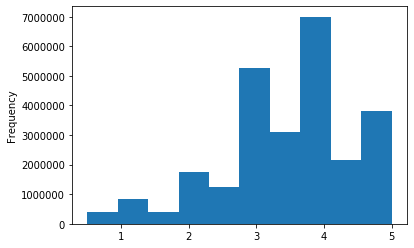

In [73]:
# 11. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load(wiki_file, kaggle_file, ratings_file)

In [74]:
# 12. Set the DataFrames from the return statement equal to the file names in Step 11. 
wiki_movies_df = wiki_file
movies_with_ratings_df = kaggle_file
movies_df = ratings_file

In [75]:
# 13. Check the wiki_movies_df DataFrame. 
wiki_movies_df.head()

,url,year,imdb_link,title,Directed by,Produced by,Screenplay by,Story by,Based on,Starring,...,Distributed by,Country,Language,Written by,Productioncompanies,imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,Renny Harlin,"[Steve Perry, Joel Silver]","[David Arnott, James Cappe, Daniel Waters]","[David Arnott, James Cappe]","[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",...,20th Century Fox,United States,English,NaN,NaN,tt0098987,21400000.0,20000000.0,1990-07-11,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet",James Foley,"[Ric Kidney, Robert Redlin]","[James Foley, Robert Redlin]",NaN,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",...,Avenue Pictures,United States,English,NaN,NaN,tt0098994,2700000.0,6000000.0,1990-05-17,114.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,Roger Spottiswoode,Daniel Melnick,"[John Eskow, Richard Rush]",NaN,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",...,TriStar Pictures,United States,"[English, Lao]",NaN,NaN,tt0099005,57718089.0,35000000.0,1990-08-10,113.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,Woody Allen,Robert Greenhut,NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",...,Orion Pictures,United States,English,Woody Allen,NaN,tt0099012,7331647.0,12000000.0,1990-12-25,106.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,John Cornell,John Cornell,NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",...,Paramount Pictures,US,English,Paul Hogan,NaN,tt0099018,6939946.0,25000000.0,1990-12-19,95.0


In [76]:
# 14. Check the movies_with_ratings_df DataFrame.
movies_with_ratings_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,3.0,0.0,3.0,2.0,5.0,26.0,37.0,46.0,16.0,11.0


In [78]:
# 15. Check the movies_df DataFrame. 
movies_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,production_countries,distributor,producers,director,starring,cinematography,editors,writers,composers,based_on
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,NaN,NaN,NaN,"[Characters, by Rex Weiner]"
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,NaN,NaN,NaN,"[the novel, After Dark, My Sweet, by, Jim Thom..."
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,NaN,NaN,NaN,"[Air America, by, Christopher Robbins]"
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,NaN,NaN,NaN,NaN
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,NaN,NaN,NaN,NaN
